<a href="https://colab.research.google.com/github/sebac820/tarea-1-recsys/blob/main/Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1

## Librerías

Importar librerías:

In [4]:
!pip3 install implicit --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 1.1 MB/s 


In [194]:
from collections import defaultdict
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from math import log2
from scipy.sparse import csr_matrix
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import heapq
data_path = '.'

In [15]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
shutil.copyfile('/content/drive/MyDrive/RecSys/transactions_train.csv', 'transactions_train.csv')
shutil.copyfile('/content/drive/MyDrive/RecSys/transactions_val.csv', 'transactions_val.csv')
shutil.copyfile('/content/drive/MyDrive/RecSys/articles.csv', 'articles.csv')
shutil.copyfile('/content/drive/MyDrive/RecSys/users_test.csv', 'users_test.csv')
shutil.copyfile('/content/drive/MyDrive/RecSys/customers.csv', 'customers.csv')

'customers.csv'

## Datasets

Importamos y visualizamos los datos de entrenamiento:

In [18]:
train_set = pd.read_csv(f'{data_path}/transactions_train.csv', header=0, index_col=0)
print(f'El dataset de entrenamiento cuenta con {train_set.shape[0]} filas y {train_set.shape[1]} columnas.')
print('Las primeras cinco filas son:')
train_set.head()

El dataset de entrenamiento cuenta con 1318501 filas y 5 columnas.
Las primeras cinco filas son:


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2


Importamos y visualizamos los datos de validación:

In [19]:
validation_set = pd.read_csv(f'{data_path}/transactions_val.csv', header=0, index_col=0)
print(f'El dataset de validación cuenta con {validation_set.shape[0]} filas y {validation_set.shape[1]} columnas.')
print('Los usuarios con más compras realizadas en el dataset de validación son:')
validation_set.head()

El dataset de validación cuenta con 140312 filas y 5 columnas.
Los usuarios con más compras realizadas en el dataset de validación son:


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-20,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,535035001,0.118627,2
1,2020-06-15,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...,654046004,0.022017,2
2,2019-10-20,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...,742086008,0.033881,2
3,2020-07-14,3219f007e898957cbe0ff0f22010cd7118c06f7498a167...,778534006,0.042356,1
4,2020-09-07,4e5c03f7ffefe2f99f8e0c9d9805c1571867e6a8dd7091...,706016015,0.033881,1


Importamos y visualizamos los datos de los productos:

In [47]:
productos = pd.read_csv(f'{data_path}/articles.csv', header=0, index_col=0)
productos.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,department_no,department_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,1339,Clean Lingerie,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,1339,Clean Lingerie,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


## Actividad 1: Análisis exploratorio

### Distribución del número de compras por usuario

Obtenemos a los 10 usuarios más activos en el dataset:

In [21]:
# Hacemos una copia del set de entrenamiento manteniendo solamente la columna 'customer_id':
compras_por_usuario = train_set.drop(columns=['t_dat', 'article_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'compras':
compras_por_usuario['compras'] = 1
# Agrupamos por 'customer_id' y contamos la cantidad de veces que se repite cada usuario en el set:
compras_por_usuario = compras_por_usuario.groupby('customer_id').count()
# Ordenamos la cuenta de cada usuario de mayor a menor:
compras_por_usuario = compras_por_usuario.sort_values(by='compras', ascending=False)
# Calculamos el porcentaje que representa cada número de compras dentro del dataset:
compras_por_usuario['porcentaje_del_dataset'] = compras_por_usuario / train_set.shape[0] * 100
# Desplegamos el porcentaje total que representa el top 10 dentro del dataset:
porcentaje_total_que_representa_el_top_10 = compras_por_usuario.iloc[0:10].sum()['porcentaje_del_dataset']
print(f'Porcentaje total que representa el top 10 dentro del dataset: {porcentaje_total_que_representa_el_top_10}%')
# Desplegamos el top 10 de usuarios más activos en el set:
display(compras_por_usuario.head(10))

Porcentaje total que representa el top 10 dentro del dataset: 0.6309437763035446%


,compras,porcentaje_del_dataset
customer_id,,
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc,1346,0.102086
84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb050070369176905712,950,0.072052
e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c72774e3f3338cbbb3335e,910,0.069018
2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8b56e5b66c86182bedf,875,0.066363
9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23704f1f654784bcda58,789,0.059841
bbebb44478948f5052c3f4c5dc04f08653e7938886a85685917fd22b92f22cd0,740,0.056124
d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9fd2fedaf1966280943,724,0.054911
ad3090d52d11671ffb43bfaa85e3620eff669e8c92c9114ba7755876254cbba8,670,0.050815
0152d53f51444891ea07013fd1fb8325415bb09bb6798a59359b21a8326d801b,664,0.050360


Así, el top 10 de usuarios con más actividad en el dataset se lleva el 0.6% de las compras, reportando más de 600 compras cada uno. Sin embargo, el resto de usuarios ha realizado una cantidad mucho menor de compras:

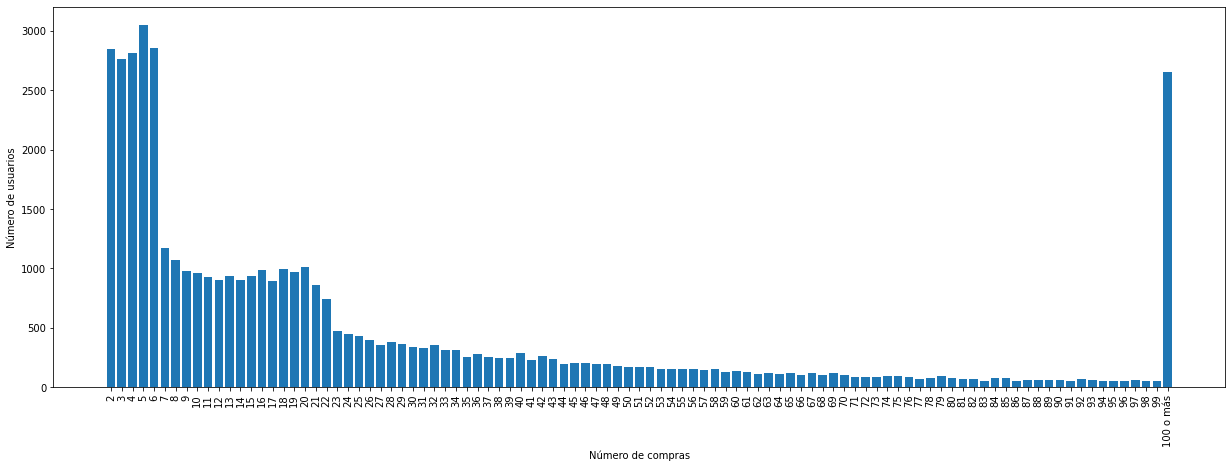

In [22]:
# Hacemos una copia del número de compras por usuario:
usuarios_por_numero_de_compras = compras_por_usuario.drop(columns=['porcentaje_del_dataset'])
# Agregamos una columna 'numero_de_usuarios':
usuarios_por_numero_de_compras['usuarios'] = 1
# Agrupamos por el número de compras, y contamos cuántos usuarios realizaron ese número de compras:
usuarios_por_numero_de_compras = usuarios_por_numero_de_compras.groupby('compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
usuarios_que_realizaron_N_o_mas_compras = usuarios_por_numero_de_compras.loc[N:]['usuarios'].sum()
usuarios_por_numero_de_compras = usuarios_por_numero_de_compras.loc[0:N-1]
usuarios_por_numero_de_compras.loc[f'{N} o más'] = usuarios_que_realizaron_N_o_mas_compras
# Graficamos:
plt.figure(figsize=(21, 7))
plt.xticks(rotation=90)
plt.bar(
    x=[i for i in range(len(usuarios_por_numero_de_compras))],
    height=[usuarios for usuarios in usuarios_por_numero_de_compras['usuarios']],
    tick_label=usuarios_por_numero_de_compras.index,
)
plt.xlabel('Número de compras')
plt.ylabel('Número de usuarios')
plt.show()

Notamos que en la distribución obtenida, la mayor parte de los usuarios han realizado solamente entre 2 a 6 compras, tras lo cual el número de usuarios que ha realizado un mayor número de compras decae rápidamente, asemejándose la curva a un decrecimiento exponencial. 

### Distribución de interacciones por producto

Obtenemos los 10 productos más comprados:

In [23]:
# Hacemos una copia del train set, dejando solamente 'article_id':
compras_por_producto = train_set.drop(columns=['t_dat', 'customer_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'compras':
compras_por_producto['compras'] = 1
# Agrupamos por producto y contamos cuántas veces fue comprado cada uno:
compras_por_producto = compras_por_producto.groupby('article_id', as_index=False).sum().sort_values(by='compras', ascending=False).merge(productos, on='article_id')
# Agregamos el porcentaje de las interacciones que representa cada producto:
compras_por_producto['porcentaje_de_interacciones'] = compras_por_producto['compras'] * 100 / train_set.shape[0]
# Calculamos el porcentaje de interacciones del top 10 de productos:
print(f'Los 10 productos más comprados representan el {compras_por_producto["porcentaje_de_interacciones"].head(10).sum()}% de las interacciones en el dataset.')
# Desplegamos los 10 productos más comprados:
compras_por_producto[['article_id', 'prod_name', 'compras', 'porcentaje_de_interacciones']].head(10)


Los 10 productos más comprados representan el 0.8631013552511528% de las interacciones en el dataset.


,article_id,prod_name,compras,porcentaje_de_interacciones
0,706016001,Jade HW Skinny Denim TRS,1978,0.150019
1,706016002,Jade HW Skinny Denim TRS,1357,0.102920
2,610776002,Tilly (1),1302,0.098749
3,372860001,7p Basic Shaftless,1225,0.092909
4,759871002,Tilda tank,1010,0.076602
5,399223001,Curvy Jeggings HW Ankle,991,0.075161
6,464297007,Greta Thong Mynta Low 3p,920,0.069776
7,562245001,Luna skinny RW,899,0.068183
8,562245046,Luna skinny RW,849,0.064391
9,372860002,7p Basic Shaftless,849,0.064391


Así, el top 10 de productos más comprados representan el 0.8% del total de interacciones en el dataset. La distribución de interacciones se observa de la siguiente manera:

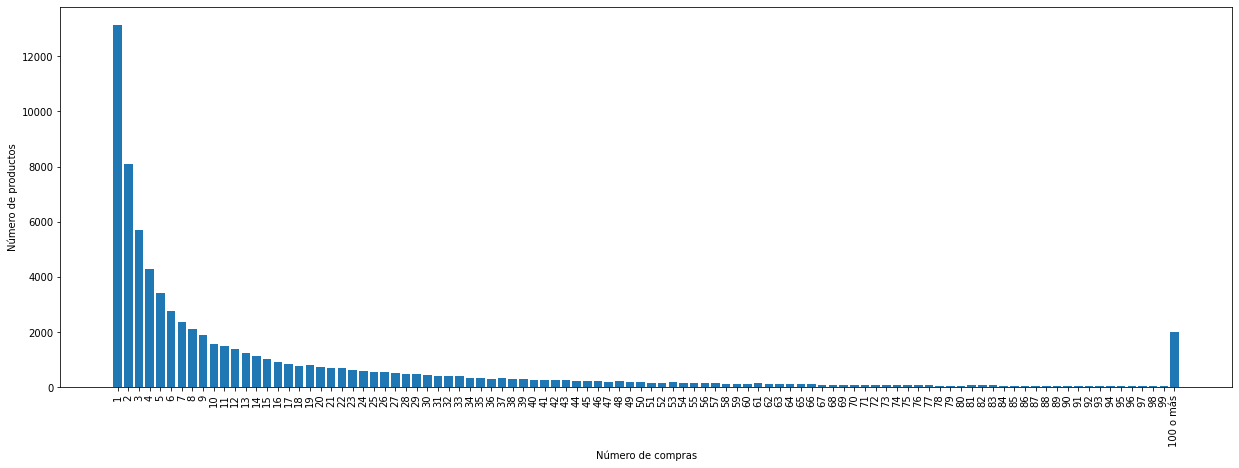

In [24]:
# Creamos una copia de compras_por_producto:
productos_por_numero_de_compras = compras_por_producto[['compras']].copy()
# Agregamos la columna 'productos':
productos_por_numero_de_compras['productos'] = 1
# Agrupamos por número de compras y contamos:
productos_por_numero_de_compras = productos_por_numero_de_compras.groupby('compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
productos_que_fueron_comprados_N_o_mas_veces = productos_por_numero_de_compras.loc[N:]['productos'].sum()
productos_por_numero_de_compras = productos_por_numero_de_compras.loc[0:N-1]
productos_por_numero_de_compras.loc[f'{N} o más'] = productos_que_fueron_comprados_N_o_mas_veces
# Graficamos:
plt.figure(figsize=(21, 7))
plt.xticks(rotation=90)
plt.xlabel('Número de compras')
plt.ylabel('Número de productos')
plt.bar(
    x=[i for i in range(len(productos_por_numero_de_compras))],
    height=[productos for productos in productos_por_numero_de_compras['productos']],
    tick_label=productos_por_numero_de_compras.index,
)
plt.show()

Notamos que la mayor parte de los productos fueron comprados 1, 2 o 3 veces, mientras que el número de productos que fueron comprados una mayor cantidad de veces es cada vez menor, asemejándose la curva a un decrecimiento exponencial.

### Tabla resumen

En el set de entrenamiento encontramos lo siguiente:

In [25]:
# Obtenemos los valores únicos:
valores_unicos = train_set.nunique()
tabla_resumen = pd.DataFrame(index=pd.CategoricalIndex(data=[], name='Variable'), columns=['Valor'])
tabla_resumen.loc['Número de usuarios distintos'] = valores_unicos['customer_id']
tabla_resumen.loc['Número de ítems distintos'] = valores_unicos['article_id']
# Obtenemos el promedio y desviación estándar de productos por usuarios:
tabla_resumen.loc['Promedio de productos por usuario'] = compras_por_usuario['compras'].mean()
tabla_resumen.loc['Desviación estándar de productos por usuario'] = compras_por_usuario['compras'].std()
# Obtenemos el promedio y desviación estándar de usuarios por productos:
tabla_resumen.loc['Promedio de usuarios por producto'] = compras_por_producto['compras'].mean()
tabla_resumen.loc['Desviación estándar de usuarios por producto'] = compras_por_producto['compras'].std()
# Obtenemos la densidad del conjunto de datos, dividiendo la cantidad de pares usuario-producto que sí están dentro del set
# por los pares que no lo están: 
tabla_resumen.loc['Densidad del conjunto de datos en cuanto a compras'] = (
    train_set[['customer_id', 'article_id']].drop_duplicates().shape[0] / (
        train_set['customer_id'].nunique() * train_set['article_id'].nunique()
    )
)
# Visualizamos los resultados:
tabla_resumen


,Valor
Variable,
Número de usuarios distintos,45000
Número de ítems distintos,73080
Promedio de productos por usuario,29.300022
Desviación estándar de productos por usuario,44.939461
Promedio de usuarios por producto,18.041886
Desviación estándar de usuarios por producto,38.01747
Densidad del conjunto de datos en cuanto a compras,0.000342


### Preparaciones para la evaluación de modelos

A continuación se definen funciones que serán de utilidad para evaluar los distintos modelos de recomendación. Primero, definimos la función `get_top_n()` para obtener el top N recomendado a cada usuario:

In [26]:
# Obtenido de la documentación de Surprise: https://surprise.readthedocs.io/en/stable/FAQ.html
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Definimos la función `ndcg()` para obtener las métricas NDCG:

In [27]:
def dcg_para_un_usuario(top_n_verdadero: list, top_n_predicho: list, arroba: int):
    # Definimos limite_del_top_n_verdadero para que no nos arroje un error de "index out of range" al comparar los
    # elementos de top_n_predicho con los de top_n_verdadero:
    limite_del_top_n_verdadero = min(arroba, len(top_n_verdadero))
    # Inicializamos la suma de gains en cero:
    dcg = 0
    # Para cada ítem dentro del límite dado por @...
    for i in range(1, arroba+1):
        item = top_n_predicho[i-1]
        # ... si el item está en el top_n_verdadero, es relevante. Si no, no:
        if item in top_n_verdadero[0:limite_del_top_n_verdadero]:
            relevante = 1
        else:
            relevante = 0
        # Sumamos el gain descontado:
        dcg += (2**relevante - 1) / log2(i + 1)
    # Retornamos el resultado final:
    return dcg

def idcg_para_un_usuario(arroba: int):
    idcg = 0
    for i in range(1, arroba+1):
        # Hacemos que todos los ítems sean relevantes:
        idcg += 1 / log2(i + 1)
    return idcg

def ndcg_para_un_usuario(top_n_verdadero: list, top_n_predicho: list, arroba: int):
    return dcg_para_un_usuario(top_n_verdadero, top_n_predicho, arroba) / idcg_para_un_usuario(arroba)

def ndcg(top_n_verdadero_para_cada_usuario: dict, top_n_predicho_para_cada_usuario: dict, arroba: int):
    suma_de_ndcgs = 0
    for usuario in top_n_verdadero_para_cada_usuario.keys():
        top_n_verdadero = top_n_verdadero_para_cada_usuario[usuario]
        top_n_predicho = top_n_predicho_para_cada_usuario[usuario]
        suma_de_ndcgs += ndcg_para_un_usuario(top_n_verdadero, top_n_predicho, arroba)
    return suma_de_ndcgs / len(top_n_verdadero_para_cada_usuario)

Definimos la función `mean_ap()` para obtener las métricas MAP:

In [28]:
def ap(top_n_verdadero: list, top_n_predicho: list, arroba: int):
    # Definimos limite_del_top_n_verdadero para que no nos arroje un error de "index out of range" al comparar los
    # elementos de top_n_predicho con los de top_n_verdadero:
    limite_del_top_n_verdadero = min(arroba, len(top_n_verdadero))
    verdaderos_positivos_hasta_el_momento = 0
    suma_de_precisiones = 0
    # Para cada ítem dentro del límite dado por @...
    for i in range(1, arroba+1):
        item = top_n_predicho[i-1]
        # ... si el item no está en el top_n_verdadero, no es relevante. Si sí lo está, es relevante:
        if not item in top_n_verdadero[0:limite_del_top_n_verdadero]:
            continue
        verdaderos_positivos_hasta_el_momento += 1
        suma_de_precisiones += verdaderos_positivos_hasta_el_momento / i
    # Retornar precisión promedio:
    if verdaderos_positivos_hasta_el_momento == 0:
        return 0
    return suma_de_precisiones / verdaderos_positivos_hasta_el_momento
    # Fórmula complementada por https://medium.com/@misty.mok/how-mean-average-precision-at-k-map-k-can-be-more-useful-than-other-evaluation-metrics-6881e0ee21a9

def mean_ap(top_n_verdadero_para_cada_usuario: dict, top_n_predicho_para_cada_usuario: dict, arroba: int):
    suma_de_aps = 0
    for usuario in top_n_verdadero_para_cada_usuario.keys():
        suma_de_aps += ap(top_n_verdadero_para_cada_usuario[usuario], top_n_predicho_para_cada_usuario[usuario], arroba)
    return suma_de_aps / len(top_n_verdadero_para_cada_usuario)

Definimos la función `evaluar()` para incorporar las métricas NDCG@10, NDCG@20, NDCG@30, MAP@10, MAP@20 y MAP@30, junto con la función `imprimir_metricas()` para visualizarlas:

In [29]:
def evaluar(top_n_verdadero_para_cada_usuario: dict, top_n_predicho_para_cada_usuario, arrobas=(10, 20, 30)):
    resultados = {'ndcg': {}, 'map': {}}
    for arroba in arrobas:
        resultados['ndcg'][arroba] = ndcg(top_n_verdadero_para_cada_usuario, top_n_predicho_para_cada_usuario, arroba)
        resultados['map'][arroba] = mean_ap(top_n_verdadero_para_cada_usuario, top_n_predicho_para_cada_usuario, arroba)
    return resultados

def imprimir_metricas(metricas: dict, arrobas=(10, 20, 30)):
    # Imprimir métricas:
    for arroba in arrobas:
        print(f'NDCG@{arroba}:', metricas['ndcg'][arroba])
    for arroba in arrobas:
        print(f'MAP@{arroba}:', metricas['map'][arroba])

Finalmente, generamos las recomendaciones "correctas" para cada usuario, considerando como "relevantes" los ítems que compró, e irrelevantes los ítems que no:

In [30]:
top_n_verdadero_para_cada_usuario = defaultdict(list)
for i in validation_set.index:
    fila = validation_set.loc[i]
    top_n_verdadero_para_cada_usuario[fila['customer_id']].append(fila['article_id'])
print('Recomendaciones \"correctas\" para un usuario de ejemplo (ID d265c0dc7e871726894c8a14e2369768af5f5315a55dc822d46e1c1d44d7d89e):')
top_n_verdadero_para_cada_usuario['d265c0dc7e871726894c8a14e2369768af5f5315a55dc822d46e1c1d44d7d89e']

Recomendaciones "correctas" para un usuario de ejemplo (ID d265c0dc7e871726894c8a14e2369768af5f5315a55dc822d46e1c1d44d7d89e):


[808305001,
 808305001,
 764624004,
 803468002,
 803468002,
 857794006,
 916000003,
 916000003,
 926164001,
 935092001]

## Actividad 2: Recomendación no personalizada

### Most Popular

Para la recomendación *most popular*, debemos obtener los 30 productos más vendidos:

In [31]:
top_30_most_popular = np.array(compras_por_producto.sort_values(by='compras', ascending=False)['article_id'][0:30])
print('IDs de los 30 productos más vendidos:')
top_30_most_popular

IDs de los 30 productos más vendidos:


array([706016001, 706016002, 610776002, 372860001, 759871002, 399223001,
       464297007, 562245001, 372860002, 562245046, 351484002, 156231001,
       673396002, 399256001, 706016003, 610776001, 673677002, 573716012,
       720125001, 448509014, 568601006, 160442007, 608776002, 158340001,
       484398001, 688537004, 599580017, 554450001, 565379001, 507909001])

Luego, recomendamos dichos productos a todos los usuarios y obtenemos las métricas de nuestra predicción:

In [32]:
# Recomendar el top 30 de productos más populares a cada uno de los usuarios:
top_30_most_popular_para_cada_usuario = defaultdict(list)
for usuario in validation_set['customer_id'].unique():
    top_30_most_popular_para_cada_usuario[usuario] = top_30_most_popular
# Obtener métricas:
imprimir_metricas(evaluar(top_n_verdadero_para_cada_usuario, top_30_most_popular_para_cada_usuario))

NDCG@10: 0.003007091961237623
NDCG@20: 0.002632137060389783
NDCG@30: 0.0022961592980431
MAP@10: 0.0092845129725025
MAP@20: 0.010244445762779046
MAP@30: 0.010616304990921407


### Random

Para la recomendación *random* seleccionamos 30 productos al azar:

In [33]:
top_30_random = np.array(random.sample(list(train_set['article_id'].unique()), k=30))
print('Los 30 ítems seleccionados aleatoriamente fueron:')
top_30_random

Los 30 ítems seleccionados aleatoriamente fueron:


array([679981002, 667870001, 717477005, 573085040, 451599002, 739827010,
       558417001, 531284014, 616598023, 843540001, 635336002, 809521001,
       682783003, 743204003, 735608002, 623869002, 796571001, 578472001,
       835852003, 633304002, 708721002, 744934012, 809628007, 590928001,
       663407001, 474915001, 579777004, 656474002, 596874001, 637223005])

Recomendamos dichos productos a todos los usuarios y obtenemos las métricas de nuestra predicción:

In [34]:
# Recomendar los 30 productos seleccionados aleatoriamente a todos los usuarios:
top_30_random_para_cada_usuario = defaultdict(list)
for usuario in validation_set['customer_id'].unique():
    top_30_random_para_cada_usuario[usuario] = top_30_random
# Calcular las métricas:
imprimir_metricas(evaluar(top_n_verdadero_para_cada_usuario, top_30_random_para_cada_usuario))

NDCG@10: 8.1853993203868e-06
NDCG@20: 2.191249227567052e-05
NDCG@30: 5.1698977495261504e-05
MAP@10: 1.9993884223649236e-05
MAP@20: 5.118150160143871e-05
MAP@30: 0.00011310164525617198


## Actividad 3: Recomendación basada en feedback implícito

### ALS

Creamos una matriz usuarios-items para entrenar los modelos, ya que ese es el formato requerido por la librería Implicit:

In [35]:
# Inicializar matriz de ceros con forma (Nº de usuarios, Nº de ítems):
matriz_usuarios_items_entrenamiento = pd.DataFrame(
    data=np.zeros(
        shape=(train_set['customer_id'].nunique(), train_set['article_id'].nunique()),
        dtype=np.bool8
    ),
    index=train_set['customer_id'].unique(),
    columns=train_set['article_id'].unique(),
    dtype=np.bool8
)
# Si el usuario interactuó con el ítem, poner el par (usuario, item) en True:
for i in train_set.index:
    fila = train_set.loc[i]
    matriz_usuarios_items_entrenamiento.loc[fila['customer_id'], fila['article_id']] = True
# Por último, convertir la matriz de tipo DataFrame a tipo CSR:
csr_usuarios_items_entrenamiento = csr_matrix(matriz_usuarios_items_entrenamiento)
csr_usuarios_items_entrenamiento

KeyboardInterrupt: ignored

Inicializamos, entrenamos y evaluamos los modelos con ALS:

In [ ]:
# Inicializamos las variables necesarias para el experimento:
factores_a_probar = (50, 100, 200, 500, 1000)
metricas_als = {}
for factores in factores_a_probar:
    metricas_als[factores] = {}

    # Instanciamos el modelo:
    modelo = AlternatingLeastSquares(factors=factores)
    # Entrenamos el modelo:
    inicio_entrenamiento = time()
    modelo.fit(user_items=csr_usuarios_items_entrenamiento)
    fin_entrenamiento = time()
    metricas_als[factores]['tiempo'] = fin_entrenamiento - inicio_entrenamiento
    
    # Recomendamos el top 10 según el modelo para cada usuario:
    top_10_predicho_para_cada_usuario = defaultdict(list)
    # Las recomendaciones de Implicit son realizadas a la posición del usuario en la matriz usuario-item, no a su ID original.
    # Por ello, iteramos sobre el rango (0, Nº de usuarios):
    for posicion_usuario in range(csr_usuarios_items_entrenamiento.shape[0]):
        # Obtenemos los top 10 ítems recomendados para el usuario en posicion_usuario.
        # Dichas recomendaciones también corresponden a la posición de los ítems en la matriz usuario-item, no a su ID:
        posiciones_de_items_recomendados = modelo.recommend(
            userid=posicion_usuario,
            user_items=csr_usuarios_items_entrenamiento[posicion_usuario],
            N=10,
            filter_already_liked_items=True
        )
        # Transformamos la posición del usuario a su verdadero ID:
        id_usuario = matriz_usuarios_items_entrenamiento.iloc[posicion_usuario].name
        # Transformamos las posiciones de los ítems recomendados a sus verdaderos IDs:
        ids_items_recomendados = [
            matriz_usuarios_items_entrenamiento.iloc[:, posicion_del_item].name for posicion_del_item in posiciones_de_items_recomendados[0]
        ]
        # Por último, le asignamos al ID del usuario las IDs de sus ítems recomendados:
        top_10_predicho_para_cada_usuario[id_usuario] = ids_items_recomendados

    # Calculamos las métricas para cada modelo:
    metricas_als[factores]['NDCG@10'] = ndcg(top_n_verdadero_para_cada_usuario, top_10_predicho_para_cada_usuario, arroba=10)
    metricas_als[factores]['MAP@10'] = mean_ap(top_n_verdadero_para_cada_usuario, top_10_predicho_para_cada_usuario, arroba=10)

    # Imprimimos los resultados:
    print(f'Métricas para ALS entrenado con {factores} factores latentes:')
    print('\tTiempo de entrenamiento:', metricas_als[factores]['tiempo'], 'segundos')
    print('\tNDCG@10:', metricas_als[factores]['NDCG@10'])
    print('\tMAP@10:', metricas_als[factores]['MAP@10'])

### BPR

Inicializamos, entrenamos y evaluamos los modelos con BPR:

In [ ]:
# Inicializamos las variables necesarias para el experimento:
factores_a_probar = (50, 100, 200, 500, 1000)
metricas_bpr = {}
for factores in factores_a_probar:
    metricas_bpr[factores] = {}

    # Instanciamos el modelo:
    modelo = BayesianPersonalizedRanking(factors=factores)
    # Entrenamos el modelo:
    inicio_entrenamiento = time()
    modelo.fit(user_items=csr_usuarios_items_entrenamiento)
    fin_entrenamiento = time()
    metricas_bpr[factores]['tiempo'] = fin_entrenamiento - inicio_entrenamiento
    
    # Recomendamos el top 10 según el modelo para cada usuario:
    top_10_predicho_para_cada_usuario = defaultdict(list)
    # Las recomendaciones de Implicit son realizadas a la posición del usuario en la matriz usuario-item, no a su ID original.
    # Por ello, iteramos sobre el rango (0, Nº de usuarios):
    for posicion_usuario in range(csr_usuarios_items_entrenamiento.shape[0]):
        # Obtenemos los top 10 ítems recomendados para el usuario en posicion_usuario.
        # Dichas recomendaciones también corresponden a la posición de los ítems en la matriz usuario-item, no a su ID:
        posiciones_de_items_recomendados = modelo.recommend(
            userid=posicion_usuario,
            user_items=csr_usuarios_items_entrenamiento[posicion_usuario],
            N=10,
            filter_already_liked_items=True
        )
        # Transformamos la posición del usuario a su verdadero ID:
        id_usuario = matriz_usuarios_items_entrenamiento.iloc[posicion_usuario].name
        # Transformamos las posiciones de los ítems recomendados a sus verdaderos IDs:
        ids_items_recomendados = [
            matriz_usuarios_items_entrenamiento.iloc[:, posicion_del_item].name for posicion_del_item in posiciones_de_items_recomendados[0]
        ]
        # Por último, le asignamos al ID del usuario las IDs de sus ítems recomendados:
        top_10_predicho_para_cada_usuario[id_usuario] = ids_items_recomendados

    # Calculamos las métricas para cada modelo:
    metricas_bpr[factores]['NDCG@10'] = ndcg(top_n_verdadero_para_cada_usuario, top_10_predicho_para_cada_usuario, arroba=10)
    metricas_bpr[factores]['MAP@10'] = mean_ap(top_n_verdadero_para_cada_usuario, top_10_predicho_para_cada_usuario, arroba=10)

    # Imprimimos los resultados:
    print(f'Métricas para BPR entrenado con {factores} factores latentes:')
    print('\tTiempo de entrenamiento:', metricas_bpr[factores]['tiempo'], 'segundos')
    print('\tNDCG@10:', metricas_bpr[factores]['NDCG@10'])
    print('\tMAP@10:', metricas_bpr[factores]['MAP@10'])

### ALS vs BPR

#### Tiempos de entrenamiento

Graficamos tiempo de entrenamiento vs factores latentes:

In [ ]:
tiempos_de_entrenamiento_als = [metricas_als[factores]['tiempo'] for factores in factores_a_probar]
tiempos_de_entrenamiento_bpr = [metricas_bpr[factores]['tiempo'] for factores in factores_a_probar]
plt.plot(factores_a_probar, tiempos_de_entrenamiento_als, label='ALS')
plt.plot(factores_a_probar, tiempos_de_entrenamiento_bpr, label='BPR')
plt.xlabel('Factores latentes')
plt.ylabel('Tiempo de entrenamiento (s)')
plt.legend()
plt.show()

Notamos que los modelos entrenados con BPR tuvieron un tiempo de entrenamiento menor a sus contrapartes entrenadas con ALS. En el caso de BPR, la variación del tiempo de entrenamiento en función de los factores latentes fue relativamente lineal, mientras que en ALS dicha variación sufrió un aumento brusco entre los 500 y los 1000 factores latentes.

#### NDCG@10

Graficamos NDCG@10 vs factores latentes:

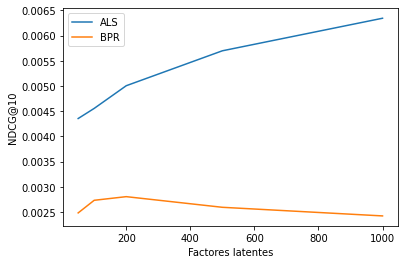

In [ ]:
ndcg_als = [metricas_als[factores]['NDCG@10'] for factores in factores_a_probar]
ndcg_bpr = [metricas_bpr[factores]['NDCG@10'] for factores in factores_a_probar]
plt.plot(factores_a_probar, ndcg_als, label='ALS')
plt.plot(factores_a_probar, ndcg_bpr, label='BPR')
plt.xlabel('Factores latentes')
plt.ylabel('NDCG@10')
plt.legend()
plt.show()

Se observa un mejor desempeño por parte de ALS para toda cantidad de factores latentes en comparación con los modelos entrenados con BPR. Para ALS se observa un aumento de NDCG@10 a medida que se aumenta la cantidad de factores latentes, mientras que BPR alcanzó su máximo NDCG@10 con 200 factores latentes, disminuyendo su desempeño desde ese punto en adelante.

#### MAP@10

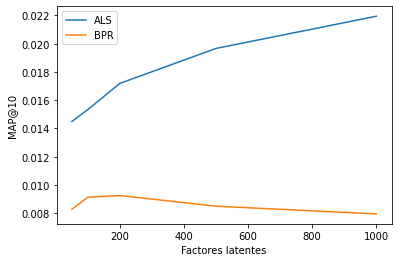

In [ ]:
map_als = [metricas_als[factores]['MAP@10'] for factores in factores_a_probar]
map_bpr = [metricas_bpr[factores]['MAP@10'] for factores in factores_a_probar]
plt.plot(factores_a_probar, map_als, label='ALS')
plt.plot(factores_a_probar, map_bpr, label='BPR')
plt.xlabel('Factores latentes')
plt.ylabel('MAP@10')
plt.legend()
plt.show()

Para las métricas MAP@10 se presentó el mismo comportamiento que las métricas NDCG@10 para ambos tipos de modelos, solo que en ambos casos se obtuvieron valores mayores que sus contrapartes en NDCG.

## Actividad 4: Recomendación basada en contenido

In [36]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Calculamos los embedings de la descripción de cada articulo en la base de datos articles.csv

In [90]:
embeded_desc = np.array([embed([str(desc)])[0] for desc in productos["detail_desc"]])
embeded_desc

array([[-0.04385931,  0.05420853, -0.04789582, ...,  0.03093391,
        -0.02633834, -0.00126313],
       [-0.04385931,  0.05420853, -0.04789582, ...,  0.03093391,
        -0.02633834, -0.00126313],
       [-0.04385931,  0.05420853, -0.04789582, ...,  0.03093391,
        -0.02633834, -0.00126313],
       ...,
       [-0.04712468,  0.0767251 , -0.05798556, ...,  0.0059746 ,
        -0.064725  ,  0.02071229],
       [-0.03299584,  0.03410223, -0.00665453, ..., -0.00174634,
        -0.06825601,  0.04235053],
       [-0.04628504,  0.03571225, -0.07564071, ..., -0.00521992,
        -0.04206318, -0.00407008]], dtype=float32)

In [102]:
embeded_desc.shape

(77650, 512)

Realizamos la reducción de dimensionalidad usando PCA, reduciendo la dimensión de los embedings desde 512 a 20 componentes

In [103]:
pca20_embeded_desc = PCA(n_components=20).fit_transform(embeded_desc)

In [237]:
pca20_embeded_desc

array([[ 0.09102032,  0.34984776,  0.0300536 , ...,  0.20597726,
         0.06474274, -0.04392194],
       [ 0.09102096,  0.34984446,  0.03005463, ...,  0.2059732 ,
         0.06473935, -0.0439216 ],
       [ 0.09102001,  0.3498455 ,  0.03005254, ...,  0.20597135,
         0.06474251, -0.04392143],
       ...,
       [-0.31419373,  0.03869586,  0.0331248 , ..., -0.00784458,
        -0.11728917, -0.02156211],
       [ 0.15237574, -0.1282774 ,  0.07821631, ..., -0.02961323,
        -0.17772426, -0.02153968],
       [ 0.212019  ,  0.07911171,  0.04312647, ...,  0.05902614,
        -0.01881888, -0.1119069 ]], dtype=float32)

Agregamos los embedings de cada producto a la tabla de productos, como una nueva columna llamada "embedings"

In [240]:
productos_con_embedings = productos
productos_con_embedings["embedings"] = ""
for i, embeding in enumerate(pca20_embeded_desc):
  productos_con_embedings.at[i, 'embedings'] = embeding
productos_con_embedings

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,department_no,department_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,embedings
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,"[0.09102032, 0.34984776, 0.030053595, 0.353470..."
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,"[0.09102096, 0.34984446, 0.030054625, 0.353478..."
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,"[0.09102001, 0.3498455, 0.030052537, 0.3534720..."
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,1339,Clean Lingerie,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...","[0.0677572, -0.086306445, 0.2790705, 0.3526952..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,1339,Clean Lingerie,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...","[0.067757174, -0.086306475, 0.27906942, 0.3526..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77645,949198001,949198,Saturday jogger,272,Trousers,Garment Lower body,1010016,Solid,9,Black,1676,Jersey Basic,16,Womens Everyday Basics,1002,Jersey Basic,Joggers in sweatshirt fabric made from a cotto...,"[0.16736302, -0.09540966, -0.23466693, -0.1997..."
77646,949551001,949551,Virgo sweater fast buy,252,Sweater,Garment Upper body,1010016,Solid,9,Black,1640,Tops Fancy Jersey,53,Divided Collection,1005,Jersey Fancy,"Short, boxy-style top in sweatshirt fabric mad...","[-0.31419373, 0.038695857, 0.0331248, -0.24385..."
77647,949551002,949551,Virgo sweater fast buy,252,Sweater,Garment Upper body,1010016,Solid,52,Pink,1640,Tops Fancy Jersey,53,Divided Collection,1005,Jersey Fancy,"Short, boxy-style top in sweatshirt fabric mad...","[-0.31419373, 0.038695857, 0.0331248, -0.24385..."
77648,952267001,952267,Heavy plain overknee tights 1p,304,Underwear Tights,Socks & Tights,1010013,Other pattern,9,Black,3608,Tights basic,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit tights with an elasticated waist tha...,"[0.15237574, -0.1282774, 0.078216314, -0.01958..."


Hacemos un join entre la tabla de compras y la de productos, para relacionar a cada usuario con los articulos que compró y sus embedings

In [163]:
customer_article = train_set[["customer_id", "article_id"]]
article_embeding = productos_con_embedings[["article_id", "embedings"]]
join = customer_article.merge(article_embeding, on="article_id")
join.head(10)

,customer_id,article_id,embedings
0,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
1,08bf5c240a09e131e9ba5a6429e660a79b13236a0249e9...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
2,270b77626c57a83d3dac0aa3e4394447d3647c9b9956de...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
3,569eb0525995f19d5dbc890447ef3b8f8e38018a937941...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
4,3f647b2a2d5774e6ea22340619bfed2580b5a800a9ca81...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
5,9928a545807e665954f34770207b3804e3d3326dba3bce...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
6,7d9262cc225a675a7e20d32098cb9fef4641075318e91e...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
7,7d9262cc225a675a7e20d32098cb9fef4641075318e91e...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
8,df313012e7bbea1d69a2672ca96968d850e2cce142222c...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."
9,35529ccf2f8504dee3b334982d19dd4cc7dbbdf8006114...,655265001,"[0.10529615, -0.05447506, -0.105143934, -0.084..."


Agrupamos por id de usuario, y calculamos el promedio de los embedings comprados por el usuario

In [180]:
customer_vec_rep = join[["customer_id", "embedings"]].groupby(['customer_id']).mean()
customer_vec_rep.head()

,embedings
customer_id,
000226b9ea81019249060b376b516f821a80e9b24f89a72106bf04b4c18b82f3,"[-0.056542784, -0.07345843, 0.04289618, 0.1091..."
000303d20b953d06dcf8c6db2d05616383a88ac84bf05482a8f5c45b3d6507b9,"[0.21371278, -0.09199065, 0.12193051, 0.400565..."
0003e7b27d3dd2295e609bcc017e96a05f322cd25fdaa717f5d2ed124a762843,"[0.0754113, -0.038841847, 0.05522002, 0.132401..."
000416152a81973bebab23142bd5dd6ebd85c8c5e2d63e18eb6398b71864f219,"[-0.03669645, 0.004980828, 0.009950718, -0.172..."
000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed6396773839f6bf71a9,"[0.07098982, -0.07800624, -0.08004244, 0.03764..."


In [282]:
def recomendacion(user_id, vec_rep=customer_vec_rep, embeding=pca20_embeded_desc, metric='euclidean', topk=10, expect="dataset_id"):
    
    user_embeding = vec_rep.loc[user_id].embedings
    productos_comprados_por_el_usuario = join[join["customer_id"] == user_id]["article_id"]

    distances = pairwise_distances(user_embeding.reshape(1,-1), embeding, metric=metric)
    heap = []
    for i in range(embeding.shape[0]): 
        #No queremos recomendar productos que ya compró
        if np.isin(productos_con_embedings.iloc[i]["article_id"], productos_comprados_por_el_usuario):
          continue
        if len(heap) < topk:
            heapq.heappush(heap, (-distances[0][i], i))
        else:
            heapq.heappushpop(heap, (-distances[0][i], i))

    heap.sort(reverse=True)
    if expect == "dataset_id":
      rec_ids = [i for _,i in heap]
    elif expect == "article_id":
      rec_ids = [productos_con_embedings.iloc[i]["article_id"] for _,i in heap]
    
    return rec_ids

A modo de ejemplo, recomendamos 10 productos para el usuario con id "000303d20b953d06dcf8c6db2d05616383a88ac84bf05482a8f5c45b3d6507b9"

In [283]:
recomendacion_ejemplo = recomendacion(user_id = "000303d20b953d06dcf8c6db2d05616383a88ac84bf05482a8f5c45b3d6507b9", metric = 'euclidean', topk=10 )
recomendacion_ejemplo

[47398, 36694, 8924, 50691, 40766, 39527, 39526, 39525, 39524, 11057]

In [284]:
recomendacion_ejemplo2 = recomendacion(user_id = "000303d20b953d06dcf8c6db2d05616383a88ac84bf05482a8f5c45b3d6507b9", metric = 'euclidean', topk=10, expect="article_id")
recomendacion_ejemplo2

[744769001,
 701162001,
 563205001,
 758040001,
 716993001,
 712483006,
 712483005,
 712483002,
 712483001,
 576692003]

Visualizamos los articulos recomendados

In [287]:
productos_con_embedings.iloc[recomendacion_ejemplo]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,department_no,department_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,embedings
47398,744769001,744769,Sandra Bikini 2-pack,299,Swimwear set,Swimwear,1010016,Solid,73,Dark Blue,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,Fully lined bikinis. Triangle top with an adju...,"[0.18545711, -0.091252424, 0.08214764, 0.39934..."
36694,701162001,701162,Alexa Bikini,299,Swimwear set,Swimwear,1010001,All over pattern,9,Black,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,Fully lined bikini. Top with narrow shoulder s...,"[0.16583057, -0.06754585, 0.11136335, 0.442272..."
8924,563205001,563205,Majorca cheeky breif,59,Swimwear bottom,Swimwear,1010001,All over pattern,9,Black,4242,Swimwear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a low waist an...,"[0.20851645, -0.11892437, 0.028377317, 0.33370..."
50691,758040001,758040,LS Emmy Padded Triangle Top,298,Bikini top,Swimwear,1010001,All over pattern,12,Light Beige,4242,Swimwear,60,"Womens Swimwear, beachwear",1018,Swimwear,LOVE STORIES x H&M. Triangle bikini top with f...,"[0.16437048, -0.095336966, 0.16480817, 0.37251..."
40766,716993001,716993,Lisa Bikini,299,Swimwear set,Swimwear,1010001,All over pattern,72,Blue,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,Fully lined patterned bikini. Triangle top wit...,"[0.15990935, -0.16249447, 0.092329465, 0.42991..."
39527,712483006,712483,Letitcia Bikini,299,Swimwear set,Swimwear,1010021,Lace,40,Other Red,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,"Fully lined bikini. Top with narrow, adjustabl...","[0.12415223, -0.1052594, 0.16993657, 0.4114155..."
39526,712483005,712483,Letitcia Bikini,299,Swimwear set,Swimwear,1010021,Lace,73,Dark Blue,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,"Fully lined bikini. Top with narrow, adjustabl...","[0.12415223, -0.1052594, 0.16993657, 0.4114155..."
39525,712483002,712483,Letitcia Bikini,299,Swimwear set,Swimwear,1010001,All over pattern,20,Other Yellow,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,"Fully lined bikini. Top with narrow, adjustabl...","[0.12415223, -0.1052594, 0.16993657, 0.4114155..."
39524,712483001,712483,Letitcia Bikini,299,Swimwear set,Swimwear,1010001,All over pattern,73,Dark Blue,4320,Young Girl Swimwear,43,"Kids Accessories, Swimwear & D",1018,Swimwear,"Fully lined bikini. Top with narrow, adjustabl...","[0.12415223, -0.1052594, 0.16993657, 0.4114155..."
11057,576692003,576692,KIANDRA bikini top,298,Bikini top,Swimwear,1010016,Solid,43,Dark Red,8396,Ladies Sport Acc,5,Ladies H&M Sport,1019,Accessories,"Fully lined bikini top with padded cups, wide ...","[0.14088224, -0.007997514, 0.24058242, 0.44227..."


Calculamos métricas del desempeño del algoritmo basado en contenido

In [288]:
# Recomendar el top 10 productos a cada uno de los usuarios:
top_10_basado_en_contenidos = defaultdict(list)
for usuario in validation_set['customer_id'].unique():
    top_10_basado_en_contenidos[usuario] = recomendacion(user_id = usuario, embeding=pca20_embeded_desc, metric = 'euclidean', topk=10, expect="article_id")
# Obtener métricas:
imprimir_metricas(evaluar(top_n_verdadero_para_cada_usuario, top_10_basado_en_contenidos))

KeyboardInterrupt: ignored

Lamentablemente este código estuvo corriendo por 1 hora y no terminó :c

Analisis de Sensibilidad:

In [289]:
def repr_vect_usuario(pca):
  productos_con_embedings = productos
  productos_con_embedings["embedings"] = ""
  for i, embeding in enumerate(pca):
    productos_con_embedings.at[i, 'embedings'] = embeding
  customer_article = train_set[["customer_id", "article_id"]]
  article_embeding = productos_con_embedings[["article_id", "embedings"]]
  join = customer_article.merge(article_embeding, on="article_id")
  customer_vec_rep = join[["customer_id", "embedings"]].groupby(['customer_id']).mean()
  return customer_vec_rep

In [ ]:
embedings_por_dimension = []
embedings_por_dimension.append(PCA(n_components=10).fit_transform(embeded_desc))
embedings_por_dimension.append(PCA(n_components=50).fit_transform(embeded_desc))
embedings_por_dimension.append(PCA(n_components=100).fit_transform(embeded_desc))
metricas_de_distancia = ["cosine", "euclidean", "manhattan"]

ndcg_basado_contenido = []
map_basado_contenido = []

for embeding in embedings_por_dimension:
  vec_rep = repr_vect_usuario(embeding)
  top_10_basado_en_contenidos = defaultdict(list)
  for usuario in validation_set['customer_id'].unique():
    top_10_basado_en_contenidos[usuario] = recomendacion(user_id = usuario, vec_rep=vec_rep, embeding=embeding, metric = 'euclidean', topk=10, expect="article_id")
  # Obtener métricas:
  resultados = evaluar(top_n_verdadero_para_cada_usuario, top_10_basado_en_contenidos, arrobas=(10))
  ndcg.append(resultados['ndcg'][10])
  map.append(resultados['map'][10])

for distancia in metricas_de_distancia:
  embeding = PCA(n_components=20).fit_transform(embeded_desc)
  vec_rep = repr_vect_usuario(embeding)
  top_10_basado_en_contenidos = defaultdict(list)
  for usuario in validation_set['customer_id'].unique():
    top_10_basado_en_contenidos[usuario] = recomendacion(user_id = usuario, vec_rep=vec_rep, embeding=embeding, metric = distancia, topk=10, expect="article_id")
  # Obtener métricas:
  resultados = evaluar(top_n_verdadero_para_cada_usuario, top_10_basado_en_contenidos, arrobas=(10))
  ndcg.append(resultados['ndcg'][10])
  map.append(resultados['map'][10])

Este tampoco terminó, principalmente porque el anterior no terminó

##Actividad 5:Comparación de métodos

Los resultados de las métricas, falta las de basado en contenido pero no se pudieron obtener debido a la razón explicada anteriormente

In [291]:
comparative = {"Algoritmo": ["Random", "Most Popular", "ALS", "BPR", "Basado en contenido"],
               "NDCG@10": [2.15719752e-05, 0.00300709, 0.00634481, 0.00280486, np.NaN],
               "MAP@10": [4.15559162e-05, 0.00928451, 0.02194264, 0.00924935, np.NaN],
               "Parametros": ["No aplica", "No aplica", "1000 factores latentes", "200 factores latentes", "PCA: NaN, Metrica: NaN"]}
df_comp = pd.DataFrame(comparative)
df_comp

,Algoritmo,NDCG@10,MAP@10,Parametros
0,Random,0.000022,0.000042,No aplica
1,Most Popular,0.003007,0.009285,No aplica
2,ALS,0.006345,0.021943,1000 factores latentes
3,BPR,0.002805,0.009249,200 factores latentes
4,Basado en contenido,NaN,NaN,"PCA: NaN, Metrica: NaN"


Aquí se realizarían las recomendaciones con el mejor algoritmo, para este caso usaremos ALS.

In [ ]:
top_10 = defaultdict(list)
for usuario in train_set['customer_id'].unique():
    top_10[usuario] = "Algoritmo de recomendación"

Lo guardamos en un json



In [ ]:
import pickle

with open('recomendaciones.json', 'wb') as fp:
    pickle.dump(top_10, fp)
